# Organización de Datos (75.06/95.58)
## Primer Cuatrimestre 2021
### Trabajo Práctico N°1
#### Curso 1: Argerich

----

##### Introducción:
En el año 2015 Nepal fue afectado por el terremoto Gorkha, un sismo que registró una
magnitud de 7.8 en la escala Richter y tuvo su epicentro en la ciudad de Kathmandu.
Aproximadamente 600,000 estructuras en el centro y pueblos aledaños fueron dañadas o
destruidas. Un análisis posterior al sismo llevado por la Comisión Nacional de
Planeamiento de Nepal comunicó que la pérdida total económica ocasionada por el
terremoto fue de aproximadamente $7 mil millones (USD; NPC, 2015).
El dataset para el presente TP está compuesto de encuestas realizadas por Kathmandu
Living Labs y el Central Bureau of Statistics y contiene información sobre el impacto del
terremoto, estado de viviendas y estadísticas sociodemográficas.
Particularmente el dataset se enfoca en cómo eran las condiciones de una determinada vivienda y cuál fue su grado de daño luego del accidente. 

##### Objetivo:
El TP consiste en realizar un análisis exploratorio de los datos provistos con el objetivo de
determinar características y variables importantes, descubrir insights interesantes, y
analizar la estructura de los mismos.

# Análisis exploratorio de los datos
#### Empecemos importando los recursos necesarios

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib as mpl
import cycler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split

#seteando la paleta de colores
estilo = "mako"
cmap_cycler = sns.color_palette(estilo, n_colors = 280)
cmap = sns.color_palette(estilo, n_colors = 2000)[:500:-1]


plt.rcParams['axes.grid'] = True
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', cmap_cycler[200::-20])
cmap_horizontal = mpl.rcParams['axes.prop_cycle'][::5]

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# lectura de archivos csv
train_values=pd.read_csv('train_values.csv',
                        dtype={
                            'geo_level_1_id':'int8',
                            'geo_level_2_id':'int16',
                            'geo_level_3_id':'int16',
                            'count_floors_pre_eq':'int8',
                            'age':'int16',
                            'area_percentage':'int8',
                            'height_percentage':'int8',
                            'land_surface_condition':'category',                 
                            'foundation_type':'category',                          
                            'roof_type':'category',                                 
                            'ground_floor_type':'category',                        
                            'other_floor_type':'category',                          
                            'position':'category',                                  
                            'plan_configuration':'category',
                            'has_superstructure_adobe_mud':'bool',               
                            'has_superstructure_mud_mortar_stone':'bool',        
                            'has_superstructure_stone_flag':'bool',             
                            'has_superstructure_cement_mortar_stone':'bool',     
                            'has_superstructure_mud_mortar_brick':'bool',        
                            'has_superstructure_cement_mortar_brick':'bool',     
                            'has_superstructure_timber':'bool',                  
                            'has_superstructure_bamboo':'bool',                  
                            'has_superstructure_rc_non_engineered':'bool',       
                            'has_superstructure_rc_engineered':'bool',          
                            'has_superstructure_other':'bool',
                            'legal_ownership_status':'category',
                            'count_families':'int8',
                            'has_secondary_use':'bool',                          
                            'has_secondary_use_agriculture':'bool',             
                            'has_secondary_use_hotel':'bool',                    
                            'has_secondary_use_rental':'bool',                  
                            'has_secondary_use_institution':'bool',             
                            'has_secondary_use_school':'bool',                
                            'has_secondary_use_industry':'bool',              
                            'has_secondary_use_health_post':'bool',         
                            'has_secondary_use_gov_office':'bool',           
                            'has_secondary_use_use_police':'bool',             
                            'has_secondary_use_other':'bool'                   
                        })
train_labels=pd.read_csv('train_labels.csv',
                        dtype={
                            'building_id':'int64',
                            'damage_grade':'int8'
                        })

### Limpieza de datos
- ¿Hay datos faltantes?
    - ¿Son muchos? Caso contrario podríamos simplemente filtrarlos.
- ¿Todos los datos están con el formato correcto?
    - ¿Es necesario transformar alguna columna a tipo categórico/numérico/date_time?
- ¿Los dataframes son muy grandes?
    - ¿Es necesario algun trabajo previo para minimizar el espacio en memoria?
- ¿Hay datos que no tengan sentido?
    - Cuyos valores sean muy grandes para el contexto
    - Que no sean posibles

#### Reviso valores null en mis dataframes

In [4]:
train_labels.isnull().any()

building_id     False
damage_grade    False
dtype: bool

In [5]:
train_values.isnull().any()

building_id                               False
geo_level_1_id                            False
geo_level_2_id                            False
geo_level_3_id                            False
count_floors_pre_eq                       False
age                                       False
area_percentage                           False
height_percentage                         False
land_surface_condition                    False
foundation_type                           False
roof_type                                 False
ground_floor_type                         False
other_floor_type                          False
position                                  False
plan_configuration                        False
has_superstructure_adobe_mud              False
has_superstructure_mud_mortar_stone       False
has_superstructure_stone_flag             False
has_superstructure_cement_mortar_stone    False
has_superstructure_mud_mortar_brick       False
has_superstructure_cement_mortar_brick  

Podemos ver que, por suerte, **ninguno de los dataframes contienen valores NaN.**  
Esto quiere decir que no será necesario ningún tipo de filtro en los datasets a causa de valores faltantes.

#### Chequeando formato de los datos

damage_grade originalmente era int64

In [6]:
train_labels.dtypes

building_id     int64
damage_grade     int8
dtype: object

Muchos valores categóricos eran objects y muchos valores booleanos eran int64, cambiamos sus tipos para optimizar.

In [7]:
train_values.dtypes

building_id                                  int64
geo_level_1_id                                int8
geo_level_2_id                               int16
geo_level_3_id                               int16
count_floors_pre_eq                           int8
age                                          int16
area_percentage                               int8
height_percentage                             int8
land_surface_condition                    category
foundation_type                           category
roof_type                                 category
ground_floor_type                         category
other_floor_type                          category
position                                  category
plan_configuration                        category
has_superstructure_adobe_mud                  bool
has_superstructure_mud_mortar_stone           bool
has_superstructure_stone_flag                 bool
has_superstructure_cement_mortar_stone        bool
has_superstructure_mud_mortar_b

#### Manejo de memoria del dataset
El valor inicialmente (sin castear las columnas al leer el csv) era de 3.97 Mb. Ahora se ve que decreció.

In [8]:
(train_labels.memory_usage()/(2**20)).sum()

2.2368783950805664

El valor inicialmente era de 77.54 Mb podemos observar que ahora la memoria se usa de forma mucho mas óptima.

In [9]:
(train_values.memory_usage()/(2**20)).sum()

12.179516792297363

#### Buscando datos fuera de lo común  
Buscamos si hay valores que no tengan sentido.

##### ¿Hay algún building_id en un dataset que **no** esté en el otro?
Los comparamos y chequeamos si hay algún false, los sumamos.

In [10]:
(train_values['building_id'] != train_labels['building_id']).sum()

0

Observamos que hay correspondencia 1 a 1 entre ambos datasets.
Eso significa que se puede hacer un merge (lo haremos mas adelante)

##### ¿Las variables geo_level_id tiene los valores que dice el enunciado?

In [11]:
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].max()

geo_level_1_id       30
geo_level_2_id     1427
geo_level_3_id    12567
dtype: int16

Vemos que se corresponde con el enunciado.

In [12]:
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].min()

geo_level_1_id    0
geo_level_2_id    0
geo_level_3_id    0
dtype: int16

Se corresponde con el enunciado.

##### ¿Hay algún valor de cantidad de familias por hogar que nos llame la atención?
No nos llama la atencion que existan algunas edificaciones con mas de 7 familias, podrían ser por ejemplo bloques de departamentos.
Tambien observamos que hay 20 mil edificaciones sin familias, esto puede ser tranquilamente por ser edificaciones destinadas a otras actividades.

In [13]:
train_values['count_families'].value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

##### ¿Hay valores raros en la cantidad de pisos por edificio?
No vemos que sea inverosimil que un solo edificio tenga 9 u 8 pisos.

In [14]:
train_values['count_floors_pre_eq'].value_counts()

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count_floors_pre_eq, dtype: int64

##### ¿Area_percentage y Height_percentage están dentro de los valores [0,100]?
Como se observa a continuación, sí.

In [15]:
train_values[['area_percentage','height_percentage']].max()

area_percentage      100
height_percentage     32
dtype: int8

In [16]:
train_values[['area_percentage','height_percentage']].min()

area_percentage      1
height_percentage    2
dtype: int8

##### ¿Hay valores fuera de lo normal para la edad de las edificaciones?

In [17]:
train_values['age'].value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
130        9
140        9
180        7
170        6
160        6
175        5
135        5
190        3
145        3
195        2
165        2
185        1
155        1
Name: age, dtype: int64

Si bien podemos observar que hay muchos edificios con antigüedades entre 0 y 200 años (lo cual
consideramos normal) podemos ver que **hay 1390 con antigüedades** de 995 años.  
Lo que nos llama la atención de esto es la brecha entre el valor 200 y 995.
- ¿Por qué no hay valores intermedios? 
- ¿Es posible que una edificación sea tan vieja?  

La forma en la que decidimos interpretar estos datos es que no se tiene una fecha concreta de la construcción de estas viviendas, pero que al ser tan antiguas (más de 200 años) se decidió ingresarlas con edades de 995 años (por eso tantas tienen exactamente esa edad).  
Para el resto de nuestro análisis consideraremos a esas viviendas como simplemente *viviendas muy viejas*

In [18]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False


In [19]:
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


#### Mergeamos los dos dataframes ya que tiene una correspondencia 1 a 1

In [20]:
df=train_values.merge(train_labels)
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3


# RandomForest
#### Híper parámetros
* n_estimators: cantidad de árboles a construir
* max_depth: máxima profundidad de cada árbol
* min_samples_split: la cantidad mínima de datos requeridos para splitear un nodo interno
* min_samples_leaf: cantidad mínima de datos requeridos para ser una hoja
* max_features: la cantidad de features a considerar cuando se busca el mejor split

## Manipulamos los features categóricos

In [21]:
df["geo_level_1_id"].value_counts()

6     24381
26    22615
10    22079
17    21813
8     19080
7     18994
20    17216
21    14889
4     14568
27    12532
13     9608
11     8220
3      7540
22     6252
25     5624
16     4332
0      4011
9      3958
12     3194
18     3189
1      2701
5      2690
30     2686
15     2320
14     1714
24     1310
23     1121
2       931
29      396
19      372
28      265
Name: geo_level_1_id, dtype: int64

In [22]:
y = pd.get_dummies(df.geo_level_1_id, prefix='geo1_')
y.head()

,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
df = df.drop('geo_level_1_id', axis =1)
df = df.join(y)

In [24]:
df = df.drop(['geo_level_2_id', 'geo_level_3_id', 'building_id'], axis=1)

In [25]:
df["land_surface_condition"].value_counts()

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

In [26]:
y = pd.get_dummies(df.land_surface_condition, prefix='lsc_')
y.head()

,lsc__n,lsc__o,lsc__t
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [27]:
df = df.drop('land_surface_condition', axis =1)
df = df.join(y)

In [28]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t
0,2,30,6,5,r,n,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,10,8,7,r,n,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,10,5,5,r,n,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,2,10,6,5,r,n,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,3,30,8,9,r,n,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
df["roof_type"].value_counts()

n    182842
q     61576
x     16183
Name: roof_type, dtype: int64

In [30]:
y = pd.get_dummies(df.roof_type, prefix='roof_')
y.head()

,roof__n,roof__q,roof__x
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [31]:
df = df.drop('roof_type', axis =1)
df = df.join(y)

In [32]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x
0,2,30,6,5,r,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,2,10,8,7,r,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,2,10,5,5,r,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,2,10,6,5,r,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,3,30,8,9,r,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [33]:
df["foundation_type"].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

In [34]:
y = pd.get_dummies(df.foundation_type, prefix='foundation_')
y.head()

,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [35]:
df = df.drop('foundation_type', axis =1)
df = df.join(y)

In [36]:
df.shape

(260601, 75)

In [37]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w
0,2,30,6,5,f,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,2,10,8,7,x,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,2,10,5,5,f,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
3,2,10,6,5,f,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,3,30,8,9,f,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0


In [38]:
df["ground_floor_type"].value_counts()

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64

In [39]:
y = pd.get_dummies(df.ground_floor_type, prefix='geound_floor_')
y.head()

,geound_floor__f,geound_floor__m,geound_floor__v,geound_floor__x,geound_floor__z
0,1,0,0,0,0
1,0,0,0,1,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [40]:
df = df.drop('ground_floor_type', axis =1)
df = df.join(y)

In [41]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w,geound_floor__f,geound_floor__m,geound_floor__v,geound_floor__x,geound_floor__z
0,2,30,6,5,q,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
1,2,10,8,7,q,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,2,10,5,5,x,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
3,2,10,6,5,x,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
4,3,30,8,9,x,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0


In [42]:
df["other_floor_type"].value_counts()

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64

In [43]:
y = pd.get_dummies(df.other_floor_type, prefix='other_floor')
y.head()

,other_floor_j,other_floor_q,other_floor_s,other_floor_x
0,0,1,0,0
1,0,1,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [44]:
df = df.drop('other_floor_type', axis =1)
df = df.join(y)

In [45]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w,geound_floor__f,geound_floor__m,geound_floor__v,geound_floor__x,geound_floor__z,other_floor_j,other_floor_q,other_floor_s,other_floor_x
0,2,30,6,5,t,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,2,10,8,7,s,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,2,10,5,5,t,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,2,10,6,5,s,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,3,30,8,9,s,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [46]:
df["position"].value_counts()

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64

In [47]:
y = pd.get_dummies(df.position, prefix='pos_')
y.head()

,pos__j,pos__o,pos__s,pos__t
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0


In [48]:
df = df.drop('position', axis =1)
df = df.join(y)

In [49]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w,geound_floor__f,geound_floor__m,geound_floor__v,geound_floor__x,geound_floor__z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos__j,pos__o,pos__s,pos__t
0,2,30,6,5,d,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,2,10,8,7,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,2,10,5,5,d,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,2,10,6,5,d,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,3,30,8,9,d,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [50]:
df["plan_configuration"].value_counts()

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

In [51]:
df = df.drop('plan_configuration', axis=1)

In [52]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w,geound_floor__f,geound_floor__m,geound_floor__v,geound_floor__x,geound_floor__z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos__j,pos__o,pos__s,pos__t
0,2,30,6,5,True,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,2,10,8,7,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,2,10,5,5,False,True,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,2,10,6,5,False,True,False,False,False,False,True,True,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,3,30,8,9,True,False,False,False,False,False,False,False,False,False,False,v,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [53]:
df["legal_ownership_status"].value_counts()

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64

In [54]:
y = pd.get_dummies(df.legal_ownership_status, prefix='ownership_')
y.head()

,ownership__a,ownership__r,ownership__v,ownership__w
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [55]:
df = df.drop('legal_ownership_status', axis =1)
df = df.join(y)

In [56]:
df.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,geo1__0,geo1__1,geo1__2,geo1__3,geo1__4,geo1__5,geo1__6,geo1__7,geo1__8,geo1__9,geo1__10,geo1__11,geo1__12,geo1__13,geo1__14,geo1__15,geo1__16,geo1__17,geo1__18,geo1__19,geo1__20,geo1__21,geo1__22,geo1__23,geo1__24,geo1__25,geo1__26,geo1__27,geo1__28,geo1__29,geo1__30,lsc__n,lsc__o,lsc__t,roof__n,roof__q,roof__x,foundation__h,foundation__i,foundation__r,foundation__u,foundation__w,geound_floor__f,geound_floor__m,geound_floor__v,geound_floor__x,geound_floor__z,other_floor_j,other_floor_q,other_floor_s,other_floor_x,pos__j,pos__o,pos__s,pos__t,ownership__a,ownership__r,ownership__v,ownership__w
0,2,30,6,5,True,True,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
1,2,10,8,7,False,True,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
2,2,10,5,5,False,True,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,2,10,6,5,False,True,False,False,False,False,True,True,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,3,30,8,9,True,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [57]:
df.dtypes

count_floors_pre_eq              int8
age                             int16
area_percentage                  int8
height_percentage                int8
has_superstructure_adobe_mud     bool
                                ...  
pos__t                          uint8
ownership__a                    uint8
ownership__r                    uint8
ownership__v                    uint8
ownership__w                    uint8
Length: 87, dtype: object

In [58]:
y = df.damage_grade

In [59]:
df = df.drop('damage_grade', axis=1)

In [60]:
df = df.join(y)

In [61]:
#raise SystemExit("Stop right there!")

In [62]:
#data = df.drop(["land_surface_condition", "foundation_type", "roof_type", "ground_floor_type", "position", "other_floor_type", "plan_configuration", "legal_ownership_status"], axis=1)
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 87 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   count_floors_pre_eq                     260601 non-null  int8 
 1   age                                     260601 non-null  int16
 2   area_percentage                         260601 non-null  int8 
 3   height_percentage                       260601 non-null  int8 
 4   has_superstructure_adobe_mud            260601 non-null  bool 
 5   has_superstructure_mud_mortar_stone     260601 non-null  bool 
 6   has_superstructure_stone_flag           260601 non-null  bool 
 7   has_superstructure_cement_mortar_stone  260601 non-null  bool 
 8   has_superstructure_mud_mortar_brick     260601 non-null  bool 
 9   has_superstructure_cement_mortar_brick  260601 non-null  bool 
 10  has_superstructure_timber               260601 non-null  bool 
 11  

In [87]:
data.head()
data.shape

(260601, 87)

In [64]:
X,y = data.iloc[:,:-1], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### híper parámetros por defecto

In [65]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)
preads = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preads))
print("RMSE: %f" % (rmse))

RMSE: 0.508336


#### Importancia de las features

In [66]:
# Gini importance
rf_model.feature_importances_

array([2.01759199e-02, 1.18123624e-01, 1.30733645e-01, 7.48465352e-02,
       8.22447763e-03, 3.10658588e-02, 8.98344524e-03, 3.53959361e-03,
       6.26207252e-03, 8.01479642e-03, 1.91206628e-02, 1.02353490e-02,
       5.08740714e-03, 1.29301868e-03, 4.64953378e-03, 2.97819058e-02,
       8.37168054e-03, 6.13007800e-03, 3.87628180e-03, 1.38307323e-03,
       2.38394618e-04, 1.08809324e-04, 5.06057899e-04, 6.24576329e-05,
       3.42466279e-05, 3.28468462e-05, 1.36824432e-03, 1.26963228e-03,
       7.58691889e-04, 5.85108864e-04, 4.83326071e-03, 1.38062623e-03,
       1.01070108e-03, 6.53352512e-03, 6.74320735e-03, 1.62629197e-02,
       1.44021952e-03, 9.73561978e-03, 5.53705702e-03, 8.46655551e-04,
       8.07871684e-03, 1.03348947e-03, 7.64361184e-04, 1.20977741e-03,
       7.10979436e-02, 9.46257261e-03, 3.76483497e-04, 2.50161721e-03,
       1.58882463e-02, 1.41947823e-03, 6.28623999e-04, 7.57750127e-04,
       1.61615304e-03, 3.19470688e-02, 1.05745112e-02, 3.70022343e-04,
      

<function matplotlib.pyplot.show(close=None, block=None)>

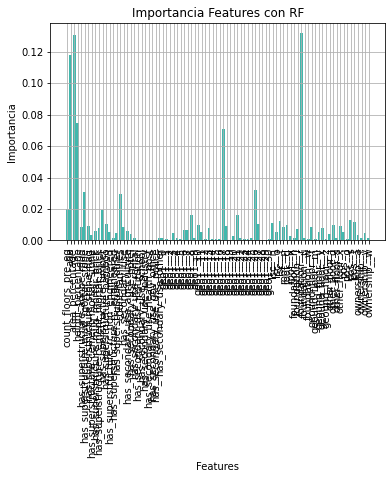

In [67]:
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importancia")
plt.title("Importancia Features con RF")
plt.xticks(rotation=90)
plt.show

#### usando solo 5 árboles

In [68]:
rf_model = RandomForestRegressor(random_state=1, n_estimators=5)
rf_model.fit(X_train, y_train)
preads = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preads))
print("RMSE: %f" % (rmse))

RMSE: 0.537729


#### usando solo 5 árboles y 7 features

In [69]:
rf_model = RandomForestRegressor(random_state=1, n_estimators=5, max_features=7)
rf_model.fit(X_train, y_train)
preads = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preads))
print("RMSE: %f" % (rmse))

RMSE: 0.534329


In [70]:
tree0 = rf_model.estimators_[0]

In [71]:
#fig = plt.figure(figsize=(25,20))
#arbol = tree.plot_tree(tree0, 
#                   feature_names=X_test.columns,  
#                   filled=True)

#resultado horrible en una foto, tarda mucho

# 🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮
![title](decistion_tree.png)
# 🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮

# XGBoost

## Hiper-parámetros

* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

## Instanciamos el regresor de XGBoost

In [72]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

## Entrenamos

In [73]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Predecimos

In [74]:
preds = xg_reg.predict(X_test)

## Calculamos el error en las predicciones

In [75]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.814053


## Entrenando y prediciendo con 100 árboles

In [76]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.492539


## Entrenando y prediciendo con 100 árboles y máxima profundidad de 4

In [77]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 4, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.495179


## K-fold cross validation

Se usa el método **cv**

Hiper-parámetros:

* **nfolds:** K del k-fold
* **num_boost_round:** cantidad de árboles a contruir (n_estimators)
* **metrics:** la métrica de evaluación a utilizar
* **as_pandas:** si los resultados lo devuelve en un DataFrame de pandas
* **early_stopping_rounds:** terminar antes si la métrica no mejora luego de una cantidad de pasadas
* **seed:** semilla para poder reproducir los resultados


## Convertimos los datos a DMatrix

In [78]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

## Entrenamos

In [79]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

## Información de los resultados

In [80]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.675684,0.000735,1.675558,0.001562
1,1.526603,0.000825,1.526546,0.001417
2,1.394377,0.000603,1.394276,0.001738
3,1.276438,0.000196,1.276445,0.002124
4,1.172679,0.001019,1.172665,0.002466


## Error final

In [81]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.498594
Name: test-rmse-mean, dtype: float64


## Visualizando los árboles

In [82]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

<AxesSubplot:>

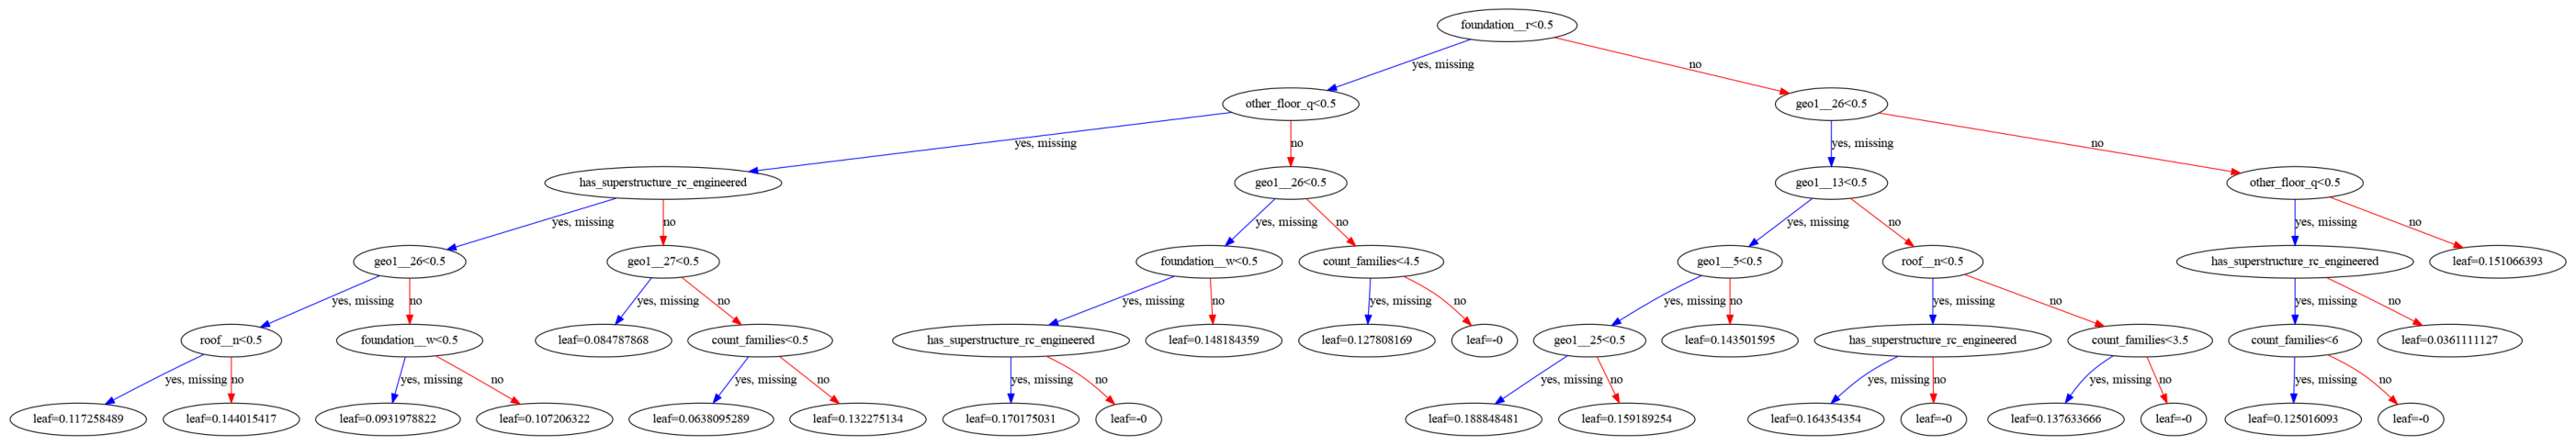

In [83]:
plt.rcParams['figure.figsize'] = [50, 50]
xgb.plot_tree(xg_reg,num_trees=0)

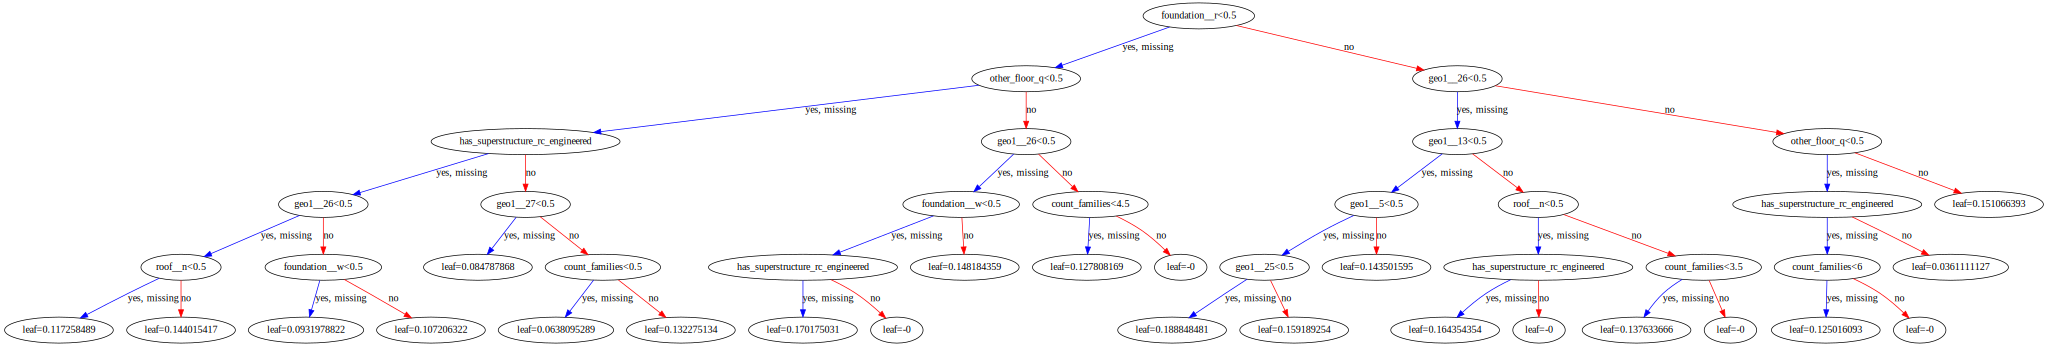

In [84]:
xgb.to_graphviz(xg_reg,num_trees=0)

## Importancia de los features (cuantas veces aparecen en los árboles)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

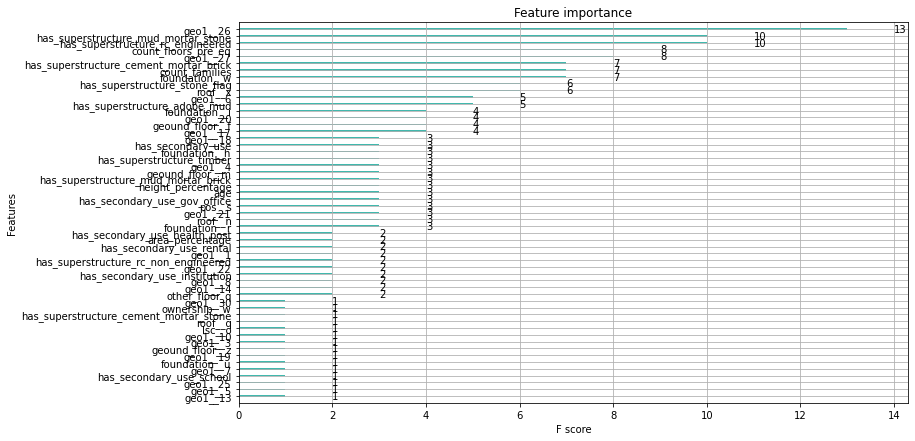

In [85]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)